# Setup

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
%cd '/content/drive/MyDrive/kaggle/kaggle_practice/항공사진_선인장_식별'

/content/drive/MyDrive/kaggle/kaggle_practice/항공사진_선인장_식별


# EDA

## 데이터 탐색

In [15]:
import pandas as pd 

data_path = 'dataset/'
labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [16]:
from zipfile import ZipFile

with ZipFile(data_path + 'train.zip') as zipper : 
  zipper.extractall()
with ZipFile(data_path + 'test.zip') as zipper : 
  zipper.extractall()  

In [22]:
labels.head(5)

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [21]:
submission.head(5)

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


## Data Visualization

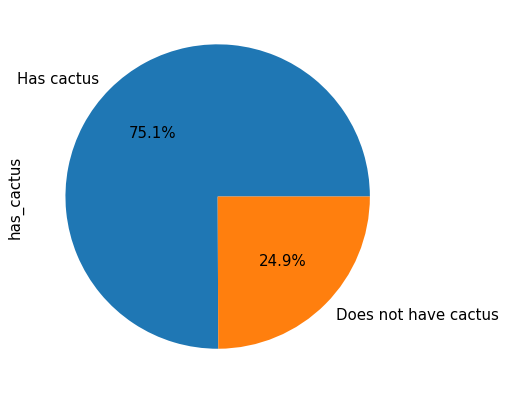

In [29]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
%matplotlib inline 

mpl.rc('font', size = 15)
plt.figure(figsize = (7, 7))
label =  ['Has cactus', 'Does not have cactus']
labels['has_cactus'].value_counts().plot.pie(labels = label, autopct = '%.1f%%')

In [31]:
import os 

num_train = len(os.listdir('train/'))
num_test = len(os.listdir('test/'))

print(f'# of train : {num_train}')
print(f'# of test : {num_test}')

# of train : 17500
# of test : 4000


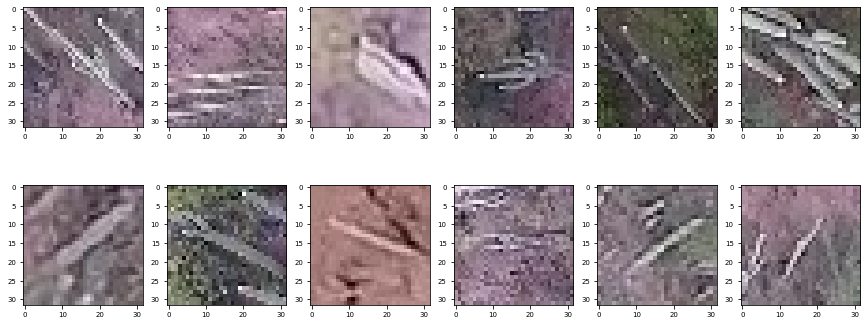

In [36]:
import matplotlib.gridspec as gridspec
import cv2

mpl.rc('font', size = 7)
plt.figure(figsize = (15, 6))
grid = gridspec.GridSpec(2, 6)

# 선인장을 포함하는 이미지 파일명(마지막 12개)
last_has_cactus_img_name = labels[labels['has_cactus'] == 1]['id'][-12:]
last_has_cactus_img_name

for idx, img_name in enumerate(last_has_cactus_img_name) : 
  img_path = 'train/' + img_name # 이미지 파일 경로
  image = cv2.imread(img_path) # 이미지 파일 읽어오기
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
  ax = plt.subplot(grid[idx]) 
  ax.imshow(image) # 이미지 출력

In [ ]:
mpl.rc('font', size = 7)
plt.figure(figsize = (15, 6))
grid = gridspec.GridSpec(2, 6)

# 선인장을 포함하는 이미지 파일명(마지막 12개)
last_has_cactus_img_name = labels[labels['has_cactus'] == 0]['id'][-12:]
last_has_cactus_img_name

for idx, img_name in enumerate(last_has_cactus_img_name) : 
  img_path = 'train/' + img_name # 이미지 파일 경로
  image = cv2.imread(img_path) # 이미지 파일 읽어오기
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
  ax = plt.subplot(grid[idx]) 
  ax.imshow(image) # 이미지 출력

In [ ]:
b